#### [ KNN기반 Bream_Smelt 식별 모델 ]
- 데이터 : 1000개 bream_smelt_best.csv
- 데이터셋 
    * 피쳐 : weight, length
    * 타겟 : Species
- 학습종류
    * 지도학습 => 분류 : 2진분류
    * 알고리즘 => 최근접이웃 알고리즘 : 거리기반=>스케일링 필요!. 메모리 고려.

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
## 모듈 로딩
import numpy as np
import pandas as pd

## 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML관련 
from sklearn.preprocessing import StandardScaler                ## 전처리
from sklearn.model_selection import train_test_split            ## 데이터
from sklearn.neighbors import KNeighborsClassifier              ## 알고리즘

In [2]:
data_file = '../Data/bream_smelt.csv'

fishDF = pd.read_csv(data_file)

[2] 데이터 확인 및 전처리 <hr>

In [3]:
## [2-1] 데이터 확인 : info()/ describe()/ .....
display(fishDF.head())
fishDF.info()

,Species,Weight,Length
0,Bream,323.587836,28.928442
1,Bream,402.087382,32.901921
2,Bream,313.261134,26.439356
3,Bream,404.993782,28.787494
4,Bream,510.314772,30.814356


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  1000 non-null   object 
 1   Weight   1000 non-null   float64
 2   Length   1000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 23.6+ KB


In [4]:
## 컬럼별 기술 통게 확인
## => weight, length 모두 음의 왜도, 왼쪽 꼬리, 오른쪽 쏠림
fishDF.describe()

,Weight,Length
count,1000.000000,1000.000000
mean,442.173820,28.804592
std,133.075903,2.662829
min,31.946399,20.836311
25%,348.529298,27.031225
50%,455.379492,29.047167
75%,540.597538,30.555417
max,777.715958,35.606743


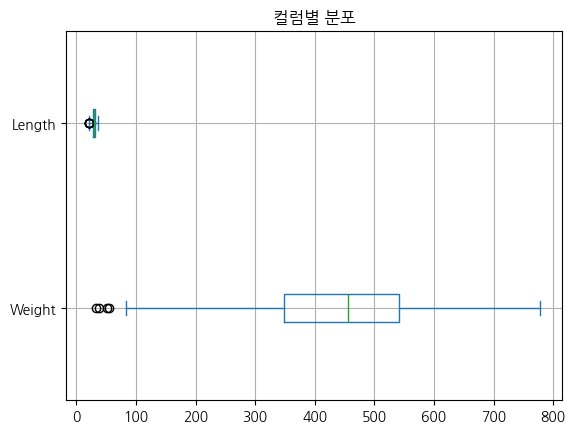

In [5]:
## ================================================
## 결측치/중복값/이상치
## ================================================
fishDF.isna().sum()       ## => 0개
fishDF.duplicated().sum()   ## -> 0개
fishDF.plot(kind='box', title='컬럼별 분포', grid=True, vert=False)
plt.show()

In [6]:
## [2-2] 데이터 타입 : 품종 컬럼 object => category
pd.options.mode.copy_on_write = True

fishDF.Species = fishDF.Species.astype('category')

fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB


[3] 학습관련 전처리 및 준비 <hr>
- 피처와 타겟 분리
- 학습용과 테스트용 데이터셋 분리
- 1개의 Data 파일경우 학습용 스케일러 생성 및 학습용/테스트용 적용

In [7]:
## [3-1] 피쳐와 타겟 분리
featureDF = fishDF[fishDF.columns[1:]]
targetSR = fishDF[fishDF.columns[0]]

print(f'featureDF => {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR => {targetSR.shape} / {targetSR.ndim}D')


featureDF => (1000, 2) / 2D
targetSR => (1000,) / 1D


In [8]:
## [3-2] 학습용과 테스트용 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size=0.2,      ## 학습/테스트 비율 정하기
                                                    random_state=42,    ## 섞기
                                                    stratify=targetSR   ## 타겟 비율 설정
                                                    )

In [9]:
## [3-3] 수치형 피쳐들 스케일 조정 : 스케일러 생성 ★학습용 데이터셋★으로 생성
## => 학습용 데이터셋 기반 스케일러 생성
stdScaler = StandardScaler()
stdScaler.fit(x_train)
print("모델 파라미터 : ",stdScaler.mean_, stdScaler.var_, stdScaler.scale_)

## 학습용/테스트용 데이터셋 스케일링 진행 => ndarray로 형 변환됨
s_x_train = stdScaler.transform(x_train)
s_x_test = stdScaler.transform(x_test)


모델 파라미터 :  [443.50053406  28.81580785] [1.80208683e+04 7.13685394e+00] [134.24182779   2.67148909]


[4] 학습진행 => 기준성능 설정 : 학습모델 기본값 그대로 학습 <hr>

In [10]:
## [4-0] 최적의 k값 찾기
best_k = 0
score_dict = {'Train': [], 'Test':[]}
for k in range(3, int((s_x_train.shape[0]) ** (1/2)) + 1) :
    kModel = KNeighborsClassifier(n_neighbors=k)
    
    ## 모델 학습
    kModel.fit(s_x_train, y_train)

    ## 모델 평가 
    score = kModel.score(s_x_train,y_train)
    tscore = kModel.score(s_x_test, y_test)
    print(k , " : ", score)
    score_dict['Train'].append(score)
    score_dict['Test'].append(tscore)

best_k


3  :  0.90875
4  :  0.895
5  :  0.905
6  :  0.90375
7  :  0.90125
8  :  0.90125
9  :  0.89875
10  :  0.90125
11  :  0.9025
12  :  0.9
13  :  0.90125
14  :  0.895
15  :  0.8975
16  :  0.895
17  :  0.8975
18  :  0.9
19  :  0.89875
20  :  0.89625
21  :  0.89875
22  :  0.89625
23  :  0.89625
24  :  0.89625
25  :  0.89125
26  :  0.89875
27  :  0.89125
28  :  0.89375


0

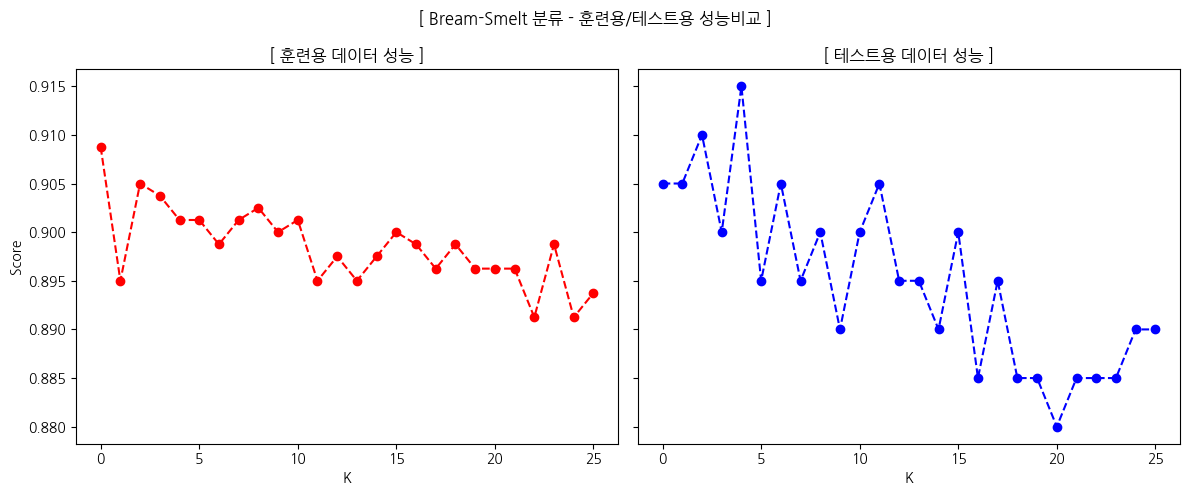

In [11]:
## ==================================================
## 적정 k 찾기 시각화
## ==================================================

## - K 개수에 따른 점수 시각화
fig, axes = plt.subplots(1,2,sharey = True, figsize=(12,5))

plt.suptitle('[ Bream-Smelt 분류 - 훈련용/테스트용 성능비교 ]')

axes[0].plot(score_dict['Train'], 'ro--')
axes[0].set_title('[ 훈련용 데이터 성능 ]')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')


axes[1].plot(score_dict['Test'], 'bo--')
axes[1].set_title('[ 테스트용 데이터 성능 ]')
axes[1].set_xlabel('K')


plt.tight_layout()
plt.show()



In [12]:
scores = pd.DataFrame(score_dict)
scores['diff'] = (scores['Train'] - scores['Test']).abs()

scores

,Train,Test,diff
0,0.90875,0.905,0.00375
1,0.89500,0.905,0.01000
2,0.90500,0.910,0.00500
3,0.90375,0.900,0.00375
4,0.90125,0.915,0.01375
5,0.90125,0.895,0.00625
6,0.89875,0.905,0.00625
7,0.90125,0.895,0.00625
8,0.90250,0.900,0.00250
9,0.90000,0.890,0.01000


In [13]:
## [4-1] 모델 인스턴스 생성
kModel = KNeighborsClassifier()
kModel

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [14]:
## [4-2] 학습 진행 => 학습용 데이터 셋
kModel.fit(s_x_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능 평가 : 테스트용 데이터셋으로 진행<hr>
- 학습용, 테스트용 성능 비교

In [15]:
## .score(2D피쳐, 1D타겟)
train_score = kModel.score(s_x_train,y_train)
test_score = kModel.score(s_x_test, y_test)

print(f'[성능비교]\n학습 점수 : {train_score}\n테스트점수 : {test_score}')

[성능비교]
학습 점수 : 0.905
테스트점수 : 0.91


[6] 일반적인 데이터 예측 서비스 <hr>
- ★반드시 예측 데이터는 스케일링이 되어야 함★

In [42]:
w = input("생선의 무게 입력 :")
l = input("생선의 길이 입력 :")

## DF 형식으로 저장
new_data=pd.DataFrame([[w, l]], columns=fishDF.columns[1:])
print(new_data)
## 스케일링 진행
s_new_data = stdScaler.transform(new_data)
print(s_new_data)


  Weight Length
0    400   27.5
[[-0.32404605 -0.49253724]]


In [43]:
## 예측 진행 
pre_target = kModel.predict(s_new_data)
proba_     = kModel.predict_proba(s_new_data)
print(f'proba => Bream : {proba_[0][0] * 100}%, Smelt : {proba_[0][1]*100}')
print(f'무게 : {w}g, 길이 : {l}cm 인 생선은 {pre_target.item()}입니다')

proba => Bream : 40.0%, Smelt : 60.0
무게 : 400g, 길이 : 27.5cm 인 생선은 Smelt입니다


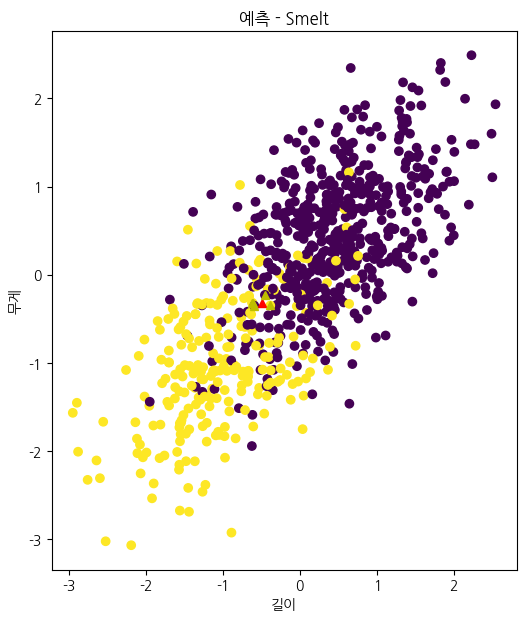

In [44]:
## 예측 검사
_,sIndices = kModel.kneighbors(s_new_data)

## 시각화
plt.figure(figsize=(6,7))
plt.scatter(s_x_train[:,1], s_x_train[:, 0], c=y_train.cat.codes)

plt.plot(s_new_data[0][1],s_new_data[0][0], '^r')


## 이웃 인덱스
sind = sIndices[0].tolist()
for x in sind :
    plt.plot(s_x_train[x][1], s_x_train[x][0], '^y')

plt.xlabel('길이')
plt.ylabel('무게')
plt.title(f'예측 - {pre_target.item()}')
plt.show()

